In [1]:
using Pkg; Pkg.activate(".")

  Activating project at `/central/groups/esm/jschmitt/experiments/feature_importance`


In [2]:
import EnsembleKalmanProcesses as EKP
import ScikitLearn
import YAML
import JLD2
import ClimaCalibrate as CAL
import CalibrateEmulateSample as CES
using Statistics
using CairoMakie
using Glob
using ClimaAnalysis
using Revise

In [3]:
includet("helper_funcs.jl")
config = YAML.load_file("experiment_config.yml")

Dict{Any, Any} with 3 entries:
  "reduction_end_time"   => 108000
  "y_var_names"          => ["ta", "hus", "clw", "cli", "pr", "rlut", "rsut", "…
  "reduction_start_time" => 64800

In [ ]:
# Initialize a nested dictionary to store profiles
parameters = glob("perturbed/*")
param_names = basename.(parameters)


function generate_perturbation_dict(short_name, perturb_amounts; zlev = nothing)
    profiles = Dict{String, Dict{String, Any}}()

    for (i, parameter) in enumerate(parameters)
        param_name = basename(parameter)
        profiles[param_name] = Dict()
        for perturb in perturb_amounts
            try
                println("Processing parameter: $param_name, perturbation: $perturb")
                # Read the parameter file
                sim_dir = SimDir(joinpath(parameter, perturb, "output_0000"))
                data = get(sim_dir; short_name = short_name, reduction = "inst")
                if data.dims["time"][end] < config["reduction_end_time"]
                    profiles[param_name][perturb] = [NaN]
                else
                    profile = window(data, "time", left = config["reduction_start_time"], right = config["reduction_end_time"])
                    averaged_profile = average_time(slice(profile, x = 0, y = 0))

                    if !haskey(averaged_profile.dims, "z")
                        profiles[param_name][perturb] = averaged_profile.data
                    else
                        profiles[param_name][perturb] = slice(averaged_profile, z = zlev).data
                    end
                    # Store the averaged profile in the nested dictionary
                end
            catch e 
                println("Error processing parameter: $param_name, perturbation: $perturb")
                println(e)
                profiles[param_name][perturb] = [NaN]
            end
        end
    end
    return profiles
end
profiles = generate_perturbation_dict("pr", string.(collect(.5:0.05:1.5)), zlev = 100)
# slice(profiles[param_names[2]]["1.0"], z = 4000).data[1]

Dict{String, Dict{String, Any}} with 11 entries:
  "mixing_length_tke_surf_… => Dict("1.35"=>[NaN], "0.9"=>[NaN], "0.95"=>fill(-…
  "mixing_length_diss_coef… => Dict("1.35"=>[NaN], "0.9"=>fill(-2.15967f-5), "0…
  "diagnostic_covariance_c… => Dict("1.35"=>fill(-2.55075f-5), "0.9"=>[NaN], "0…
  "entr_param_vec"          => Dict("1.35"=>fill(-2.5104f-5), "0.9"=>[NaN], "0.…
  "EDMF_surface_area"       => Dict("1.35"=>fill(-2.54828f-5), "0.9"=>fill(-2.1…
  "mixing_length_eddy_visc… => Dict("1.35"=>fill(-2.26922f-5), "0.9"=>fill(-2.2…
  "turb_entr_param_vec"     => Dict("1.35"=>fill(-2.58302f-5), "0.9"=>[NaN], "0…
  "pressure_normalmode_dra… => Dict("1.35"=>fill(-2.70024f-5), "0.9"=>fill(-2.3…
  "mixing_length_Prandtl_n… => Dict("1.35"=>fill(-2.32426f-5), "0.9"=>fill(-2.4…
  "mixing_length_static_st… => Dict("1.35"=>fill(-2.35571f-5), "0.9"=>[NaN], "0…
  "pressure_normalmode_buo… => Dict("1.35"=>fill(-2.95094f-5), "0.9"=>fill(-2.0…

In [10]:
profiles["EDMF_surface_area"]["1.35"][1]

296.7694f0

In [ ]:

function statistic_parameter_plot(statistic, zlev = 0; purturbations = string.(collect(.5:0.05:1.5)))
    # access the data
    profiles = generate_perturbation_dict(statistic, purturbations, zlev = zlev);

    fig = Figure(size = (250 * min(length(param_names), 5), 250 * ceil(Int, length(param_names) / 5)))  # Adjust figure size
    for (i, param_name) in enumerate(param_names)
        row = div(i - 1, 5) + 1  # Calculate row index
        col = mod(i - 1, 5) + 1  # Calculate column index
        ax = Axis(fig[row, col], title = param_name, xlabel = "Fraction of Prior Mean Value", ylabel = statistic)
        resultant_perturbed_amounts = collect(keys(profiles[param_name]))
        obs = [profiles[param_name][perturb][1] for perturb in resultant_perturbed_amounts]
        obs = hcat(obs...)[:]
        valid_idx = .!isnan.(obs)
        xvals = parse.(Float64, resultant_perturbed_amounts)[valid_idx]
        obs = obs[valid_idx]
        scatter!(ax, xvals, obs, label = "Observations")
    end

    fig
    # save fig 
    save("figures/single_var_perturbations/$(statistic)_$(zlev).png", fig)
    return profiles
end

statistic_parameter_plot("pr", 0)

Dict{String, Dict{String, Any}} with 11 entries:
  "mixing_length_tke_surf_… => Dict("1.35"=>[NaN], "0.9"=>[NaN], "0.95"=>fill(-…
  "mixing_length_diss_coef… => Dict("1.35"=>[NaN], "0.9"=>fill(-2.15967f-5), "0…
  "diagnostic_covariance_c… => Dict("1.35"=>fill(-2.55075f-5), "0.9"=>[NaN], "0…
  "entr_param_vec"          => Dict("1.35"=>fill(-2.5104f-5), "0.9"=>[NaN], "0.…
  "EDMF_surface_area"       => Dict("1.35"=>fill(-2.54828f-5), "0.9"=>fill(-2.1…
  "mixing_length_eddy_visc… => Dict("1.35"=>fill(-2.26922f-5), "0.9"=>fill(-2.2…
  "turb_entr_param_vec"     => Dict("1.35"=>fill(-2.58302f-5), "0.9"=>[NaN], "0…
  "pressure_normalmode_dra… => Dict("1.35"=>fill(-2.70024f-5), "0.9"=>fill(-2.3…
  "mixing_length_Prandtl_n… => Dict("1.35"=>fill(-2.32426f-5), "0.9"=>fill(-2.4…
  "mixing_length_static_st… => Dict("1.35"=>fill(-2.35571f-5), "0.9"=>[NaN], "0…
  "pressure_normalmode_buo… => Dict("1.35"=>fill(-2.95094f-5), "0.9"=>fill(-2.0…

In [ ]:
for statistic in config["y_var_names"]
    println(statistic)
    if statistic in ["ta", "hus", "clw", "cli"]
        for zlev in [100, 500, 1000, 1500, 2000, 2500]
            statistic_parameter_plot(statistic, zlev);
        end
    else 
        statistic_parameter_plot(statistic, 0);
    end
end

UndefVarError: UndefVarError: `experiment_config` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

In [18]:
t = generate_perturbation_dict("pr",  string.(collect(.5:0.05:1.5)), zlev = 0)

Dict{String, Dict{String, Any}} with 11 entries:
  "mixing_length_tke_surf_… => Dict("1.35"=>[NaN], "0.9"=>[NaN], "0.95"=>[NaN],…
  "mixing_length_diss_coef… => Dict("1.35"=>[NaN], "0.9"=>[NaN], "0.95"=>[NaN],…
  "diagnostic_covariance_c… => Dict("1.35"=>[NaN], "0.9"=>[NaN], "0.95"=>[NaN],…
  "entr_param_vec"          => Dict("1.35"=>[NaN], "0.9"=>[NaN], "0.95"=>[NaN],…
  "EDMF_surface_area"       => Dict("1.35"=>[NaN], "0.9"=>[NaN], "0.95"=>[NaN],…
  "mixing_length_eddy_visc… => Dict("1.35"=>[NaN], "0.9"=>[NaN], "0.95"=>[NaN],…
  "turb_entr_param_vec"     => Dict("1.35"=>[NaN], "0.9"=>[NaN], "0.95"=>[NaN],…
  "pressure_normalmode_dra… => Dict("1.35"=>[NaN], "0.9"=>[NaN], "0.95"=>[NaN],…
  "mixing_length_Prandtl_n… => Dict("1.35"=>[NaN], "0.9"=>[NaN], "0.95"=>[NaN],…
  "mixing_length_static_st… => Dict("1.35"=>[NaN], "0.9"=>[NaN], "0.95"=>[NaN],…
  "pressure_normalmode_buo… => Dict("1.35"=>[NaN], "0.9"=>[NaN], "0.95"=>[NaN],…

In [ ]:
fig = Figure(size = (250 * min(length(param_names), 5), 250 * ceil(Int, length(param_names) / 5)))  # Adjust figure size
var_name = "ta"
for (i, param_name) in enumerate(param_names)
    println(param_name)
    row = div(i - 1, 5) + 1  # Calculate row index
    col = mod(i - 1, 5) + 1  # Calculate column index
    ax = Axis(fig[row, col], title = param_name, xlabel = "Perturbation", ylabel = var_name)
    resultant_perturbed_amounts = collect(keys(profiles[param_name]))
    println(resultant_perturbed_amounts)
    obs = [profiles[param_name][perturb][1] for perturb in resultant_perturbed_amounts]
    println(obs)
    obs = hcat(obs...)[:]
    println(obs)
    @info size(resultant_perturbed_amounts)
    valid_idx = .!isnan.(obs)
    xvals = parse.(Float64, resultant_perturbed_amounts)[valid_idx]
    obs = obs[valid_idx]
    scatter!(ax, xvals, obs, label = "Observations")
end

fig
# save fig 
save("figures/single_var_perturbations/ta_100.png", fig)

In [82]:
fig = Figure(size = (400, 1600))
for (ind, param_name) in enumerate(param_names)
    ax = Axis(fig[1, ind], title = param_name, xlabel = "Time", ylabel = "rsut")
    obs = [profiles[param_name][perturb].data for perturb in perturb_amounts]
    #obs = hcat(obs...)
    scatter!(ax, [0.8, 1.0, 1.2], obs)
end

ArgumentError: ArgumentError:     Conversion failed for Scatter (With conversion trait PointBased()) with args: Tuple{Vector{Float64}, Vector{Array{Float32, 0}}} .
    Scatter requires to convert to argument types Tuple{AbstractVector{<:Union{Point2, Point3}}}, which convert_arguments didn't succeed in.
    To fix this overload convert_arguments(P, args...) for Scatter or PointBased() and return an object of type Tuple{AbstractVector{<:Union{Point2, Point3}}}.`


In [ ]:
# read all the parameter directories
parameters = glob("perturbed/*")
# get the perturbation amounts
perturb_amounts = readdir(parameters[1])
var = "ta"

t = nothing 
for parameter in parameters
    for perturb in perturb_amounts
        # read the parameter file
        sim_dir = SimDir(joinpath(parameter, perturb, "output_active"))
        var = get(sim_dir; short_name = var, reduction = "inst")
        profile = window(t, "time", left = config["reduction_start_time"], right = config["reduction_end_time"])
        averaged_profile = average_time(slice(profile, x = 0, y = 0));
        t = var
    end
end

Attributes:
  units      => K
  short_name => ta
  long_name  => Air Temperature, Instantaneous
  start_date => 2007-07-01T00:00:00
  comments   => 
Dimension attributes:
  time:
    units         => s
    axis          => T
    long_name     => Time
    standard_name => time
  x:
    units => m
    axis  => X
  y:
    units => m
    axis  => Y
  z:
    units => m
    axis  => Z
Data defined over:
  time with 187 elements (0.0 to 111600.0)
  x    with 2 elements (0.0 to 1.0)
  y    with 2 elements (0.0 to 1.0)
  z    with 200 elements (15.0 to 44759.664)Attributes:
  units      => K
  short_name => ta
  long_name  => Air Temperature, Instantaneous
  start_date => 2007-07-01T00:00:00
  comments   => 
Dimension attributes:
  time:
    units         => s
    axis          => T
    long_name     => Time
    standard_name => time
  x:
    units => m
    axis  => X
  y:
    units => m
    axis  => Y
  z:
    units => m
    axis  => Z
Data defined over:
  time with 187 elements (0.0 to 111600

In [ ]:
profile = window(t, "time", left = config["reduction_start_time"], right = config["reduction_end_time"])
averaged_profile = average_time(slice(profile, x = 0, y = 0));



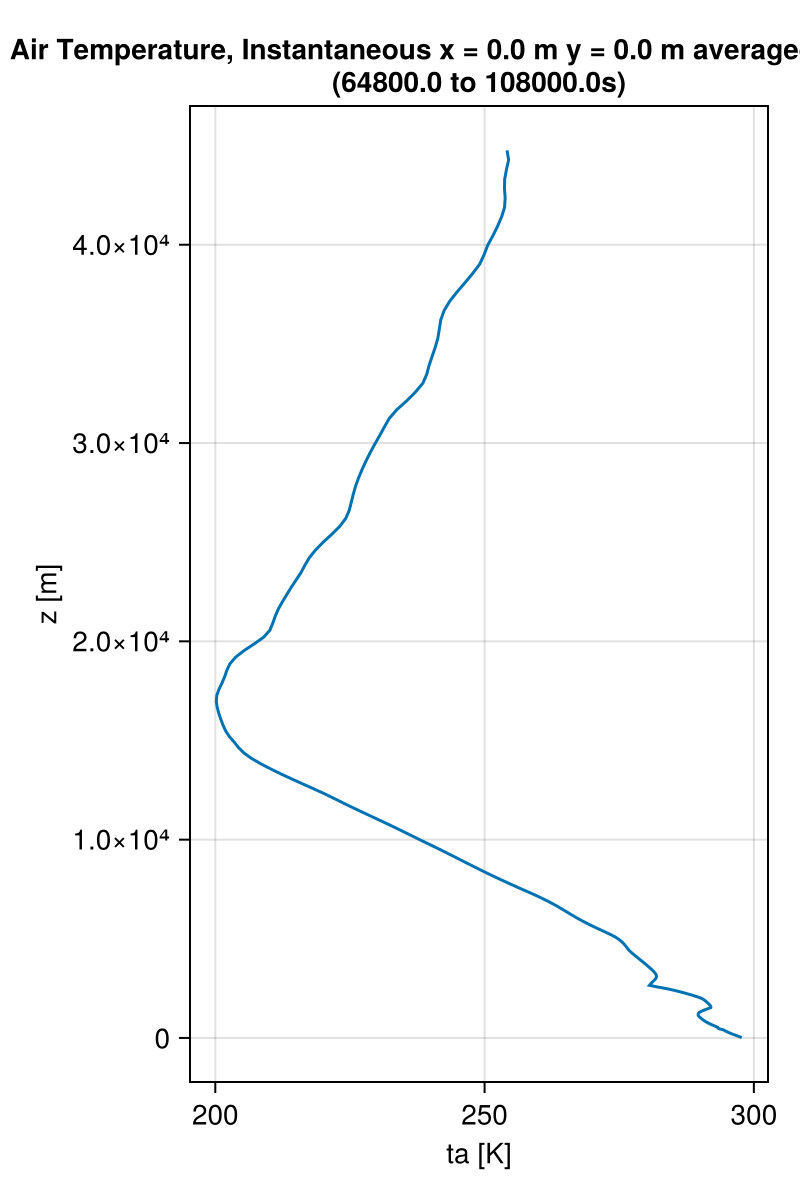

In [50]:
fig = Figure(size = (400, 600))

Visualize.plot!(
    fig, 
    averaged_profile,
    more_kwargs = Dict(:axis => ClimaAnalysis.Utils.kwargs(dim_on_y = true)),
)
fig